## 飞桨学习赛：英雄联盟大师预测2023年2月85.365分方案
### 比赛链接 - [飞桨学习赛：英雄联盟大师预测](https://aistudio.baidu.com/aistudio/competition/detail/247/0/introduction)
### 赛题介绍

本赛题属于典型的分类问题，以英雄联盟手游为背景，要求选手根据英雄联盟玩家的实时游戏数据，预测玩家在本局游戏中的输赢情况。

### 数据说明

数据集中每一行为一个玩家的游戏数据，数据字段如下所示：

- id：玩家记录id
- win：是否胜利，标签变量
- kills：击杀次数
- deaths：死亡次数
- assists：助攻次数
- largestkillingspree：最大 killing spree（游戏术语，意味大杀特杀。当你连续杀死三个对方英雄而中途没有死亡时）
- largestmultikill：最大mult ikill（游戏术语，短时间内多重击杀）
- longesttimespentliving：最长存活时间
- doublekills：doublekills次数
- triplekills：doublekills次数
- quadrakills：quadrakills次数
- pentakills：pentakills次数
- totdmgdealt：总伤害
- magicdmgdealt：魔法伤害
- physicaldmgdealt：物理伤害
- truedmgdealt：真实伤害
- largestcrit：最大暴击伤害
- totdmgtochamp：对对方玩家的伤害
- magicdmgtochamp：对对方玩家的魔法伤害
- physdmgtochamp：对对方玩家的物理伤害
- truedmgtochamp：对对方玩家的真实伤害
- totheal：治疗量
- totunitshealed：痊愈的总单位
- dmgtoturrets：对炮塔的伤害
- timecc：法控时间
- totdmgtaken：承受的伤害
- magicdmgtaken：承受的魔法伤害
- physdmgtaken：承受的物理伤害
- truedmgtaken：承受的真实伤害
- wardsplaced：侦查守卫放置次数
- wardskilled：侦查守卫摧毁次数
- firstblood：是否为firstblood

测试集中label字段win为空，需要选手预测。

### 比赛难点

本次比赛难点主要在于数据处理和模型选择上

- 比赛数据既没有缺失值也没有特别明显的异常值，数据分布比较正常，特征工程上找不到很多能增长准确率的地方
- 事实上就算不做任何数据处理直接用随机森例、LightGBM和xgboost模型都能够非常轻松的拿到82-84分神经网络模型也并不能够有很大程度的进步甚至不如树模型

### 项目亮点

- 采用遗传算法构造了更多特征并利用PCA算法进行特征降维

- 利用Dense Connetion思想设计网络结构防止梯度消失


### 代码仓库

https://github.com/ZhangzrJerry/paddle-lolmp

1. 解压数据

In [1]:
!unzip -d data/ data/data137276/test.csv.zip
!unzip -d data/ data/data137276/train.csv.zip
!pip install -r requirements.txt  -i https://pypi.tuna.tsinghua.edu.cn/simple/
!mkdir result pretrain

Archive:  data/data137276/test.csv.zip
  inflating: data/test.csv           
Archive:  data/data137276/train.csv.zip
  inflating: data/train.csv          
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 2.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 682.1 kB/s eta 0:00:00a 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=6ae026c23d9c6a62321edd556da9ca4e035a4bc23b4c36f5cc1abb48cd91873b
  Stored in directory: /home/aistudio/.cache/pip/wheels/5c

In [12]:
import numpy as np
import pandas as pd

x_train = pd.read_csv('data/train.csv').drop('win',axis=1)
y_train = pd.read_csv('data/train.csv')['win']
x_test = pd.read_csv('data/test.csv')

# 拼接后方便特征工程
feature = pd.concat([x_train, x_test])

2. 数据可视化

                  id          kills         deaths        assists  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean    99999.500000       5.798545       5.810190       8.322870   
std     57735.171256       4.605316       3.263815       5.933893   
min         0.000000       0.000000       0.000000       0.000000   
25%     49999.750000       2.000000       3.000000       4.000000   
50%     99999.500000       5.000000       6.000000       7.000000   
75%    149999.250000       8.000000       8.000000      12.000000   
max    199999.000000      39.000000      23.000000      52.000000   

       largestkillingspree  largestmultikill  longesttimespentliving  \
count        200000.000000     200000.000000           200000.000000   
mean              2.671450          1.332095              630.531655   
std               2.537784          0.758037              311.568408   
min               0.000000          0.000000                0.000000   
25%               

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


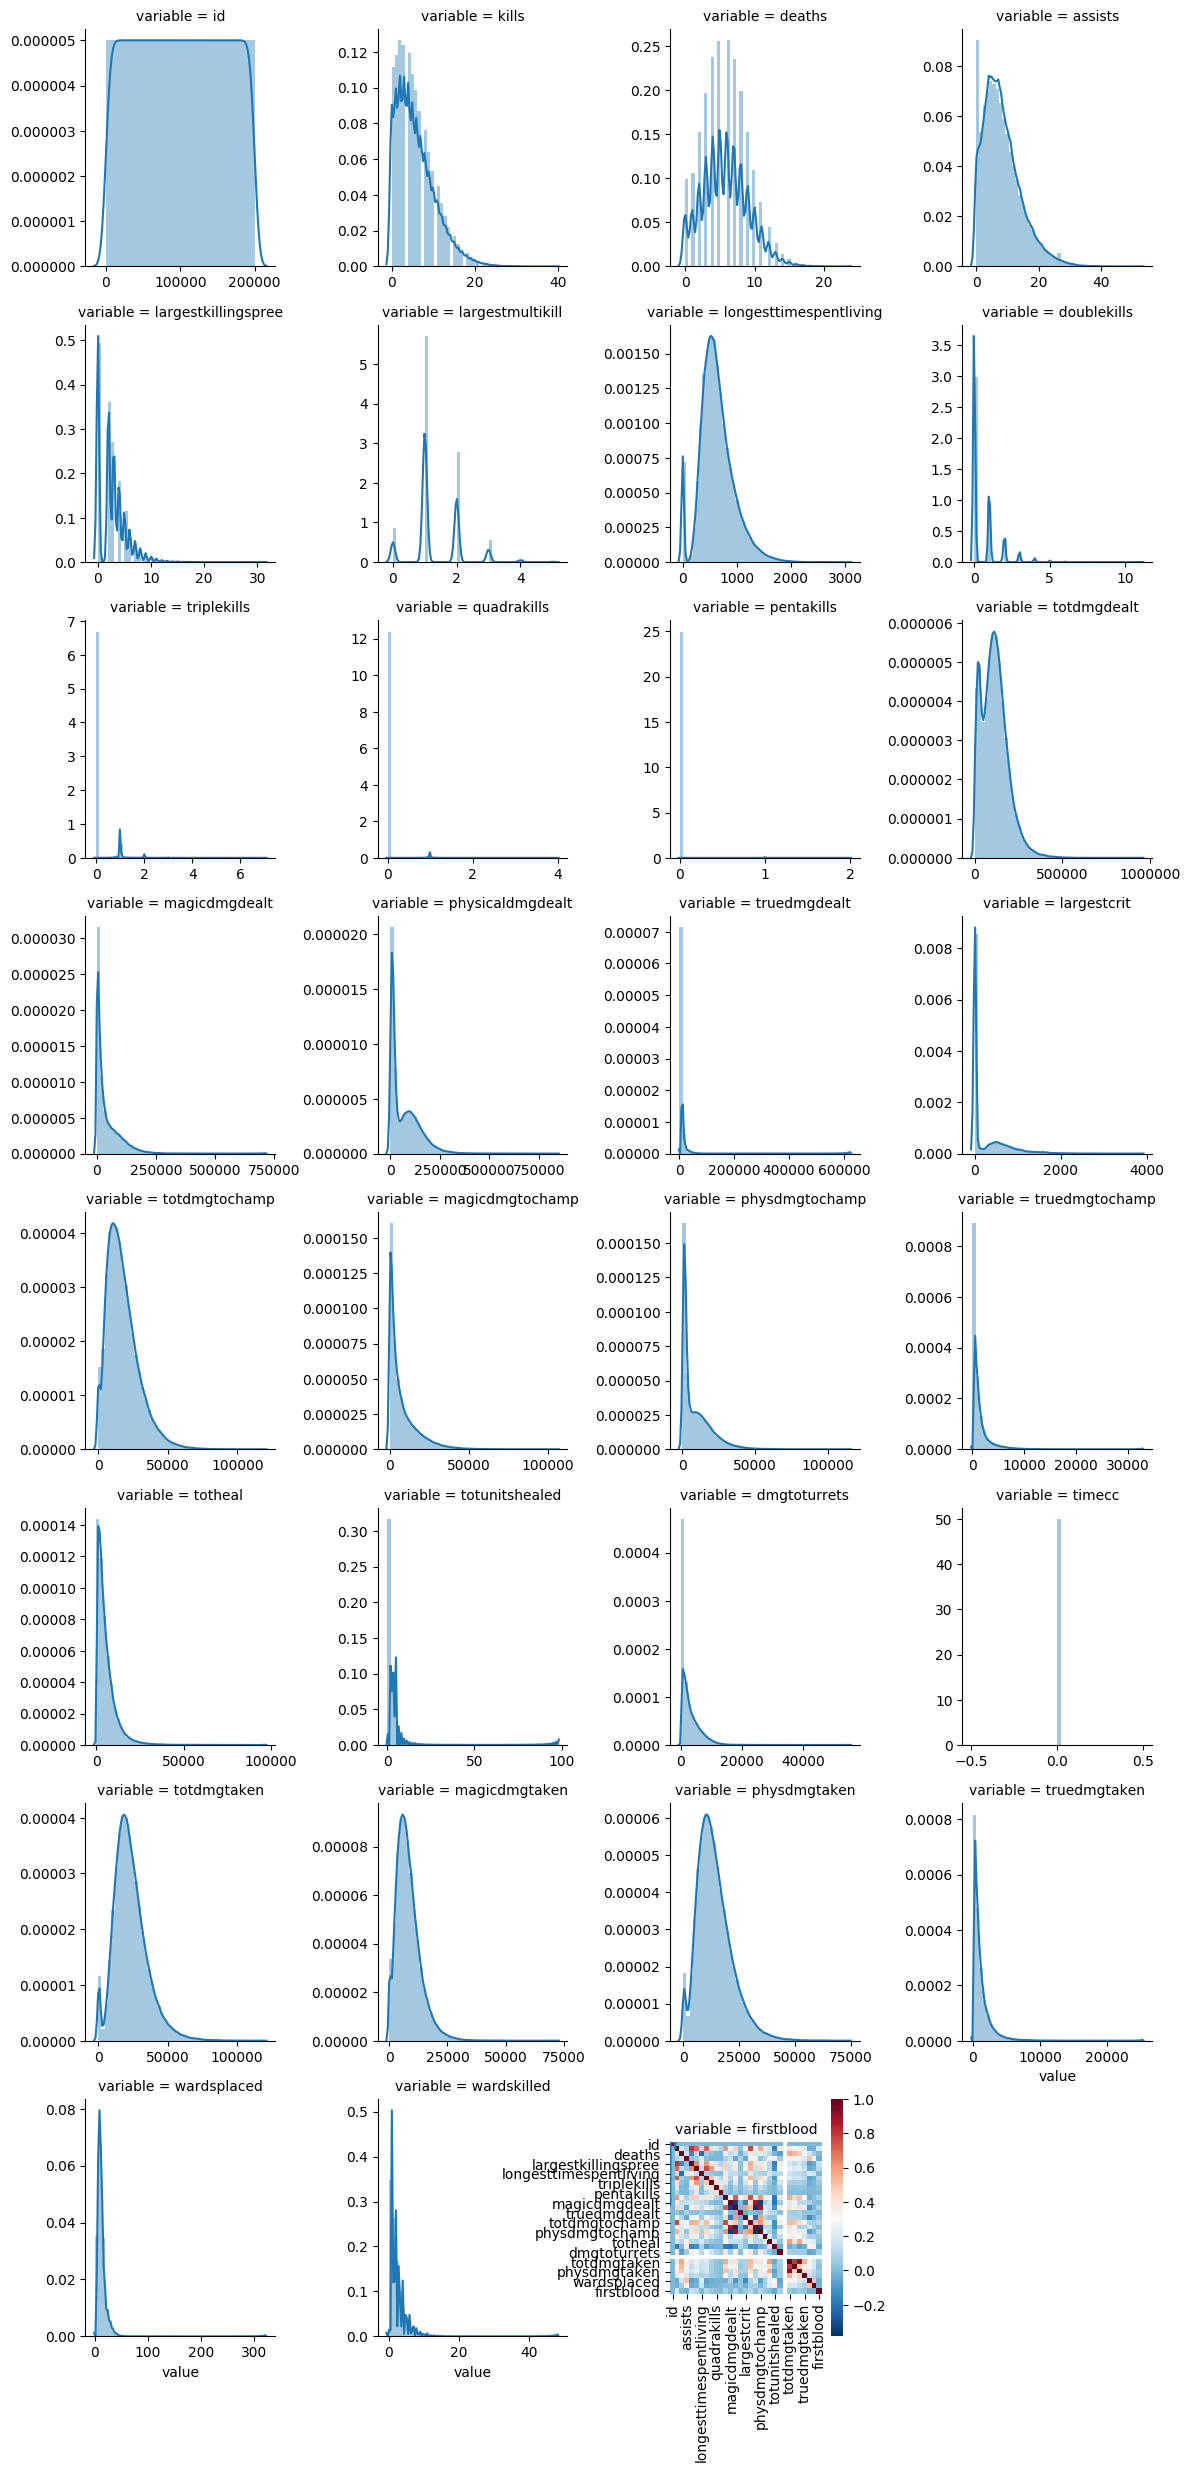

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 查看数据的信息
print(feature.describe())
print(feature.info())

# 查看数据分布特征
sns.FacetGrid(pd.melt(feature), col="variable",  col_wrap=4, sharex=False, sharey=False).map(sns.distplot, "value")

# 查看数据相关性
sns.set_context({"figure.figsize":(8,8)})
sns.heatmap(data=feature.corr(),square=True,cmap='RdBu_r')

3. 数据预处理

In [13]:
from category_encoders import *
from sklearn.preprocessing import MinMaxScaler

# 对离散变量顺序编码
columns= ['kills','deaths','assists', 'largestkillingspree',
    'largestmultikill', 'longesttimespentliving', 'doublekills',
    'triplekills', 'quadrakills', 'pentakills','firstblood']
m_feature = OrdinalEncoder(cols=columns).fit(feature).transform(feature)
m_feature.columns=[
    'id', 'akills', 'adeaths', 'aassists', 'alargestkillingspree',
       'alargestmultikill', 'alongesttimespentliving', 'adoublekills',
       'atriplekills', 'aquadrakills', 'apentakills', 'totdmgdealt',
       'magicdmgdealt', 'physicaldmgdealt', 'truedmgdealt', 'largestcrit',
       'totdmgtochamp', 'magicdmgtochamp', 'physdmgtochamp', 'truedmgtochamp',
       'totheal', 'totunitshealed', 'dmgtoturrets', 'timecc', 'totdmgtaken',
       'magicdmgtaken', 'physdmgtaken', 'truedmgtaken', 'wardsplaced',
       'wardskilled', 'afirstblood'
]
m_feature=pd.concat([m_feature,feature[columns]],axis=1).drop(['timecc','id'],axis=1)

# 对特征归一化
sc = MinMaxScaler().fit(m_feature)
feature = sc.transform(m_feature)

pd.DataFrame(feature).to_csv('pretrain/feature.csv',index=False)

pd.DataFrame(feature[:180000]).to_csv('pretrain/train_feature.csv',index=False)
pd.DataFrame(feature[180000:]).to_csv('pretrain/test_feature.csv',index=False)

4. 自动挖掘特征

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.03        0.0967885        4         0.395269         0.413457      2.82m
   1     6.91         0.250165        5         0.512841         0.518938      1.67m
   2     4.82         0.322645        7         0.600911         0.603908      1.49m
   3     5.58         0.365057       12         0.604385         0.606605      1.34m
   4     6.48         0.414963        9         0.615257         0.610385      1.35m
   5     8.58         0.468763        9         0.628536         0.620473      1.22m
   6    11.07         0.508876       15         0.638086         0.641776      1.18m
   7    13.61         0.514324       11         0.640324         0.636264      1.12m
   8    14.01         0.540671       39         0.656748         0.657258  

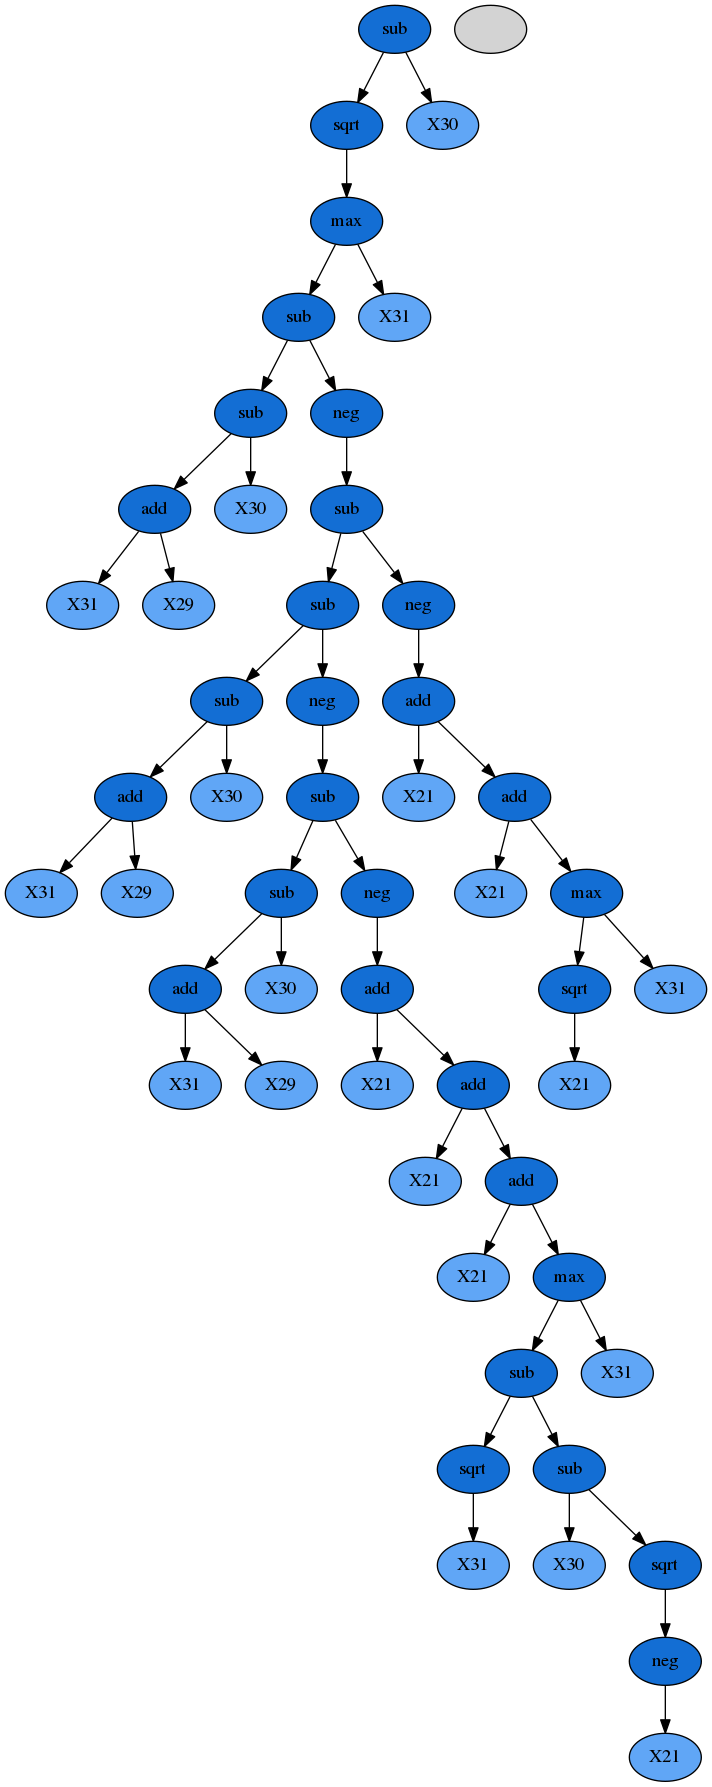

In [14]:
from gplearn.genetic import SymbolicTransformer
from IPython.display import Image
import pydotplus
import numpy as np
import pandas as pd

function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']

st = SymbolicTransformer(
    generations=20,
    population_size=1000,
    hall_of_fame=100,
    n_components=100,
    function_set=function_set,
    parsimony_coefficient=0.0005,
    max_samples=0.9,
    verbose=1,
    random_state=0,
    n_jobs=3
)

st.fit(np.array(pd.read_csv('pretrain/train_feature.csv')),np.array(pd.read_csv('data/train.csv')['win']))

graph = st._best_programs[0].export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
display(Image(graph.create_png()))

pd.DataFrame(
    np.concatenate(
        [
            st.transform(
                np.array(
                    pd.read_csv('pretrain/train_feature.csv')
                )
            ),
            np.array(
                pd.read_csv('pretrain/train_feature.csv')
            )
        ],
        axis=1
    )
).to_csv('pretrain/gptrain.csv',index=False)

pd.DataFrame(
    np.concatenate(
        [
            st.transform(
                np.array(
                    pd.read_csv('pretrain/test_feature.csv')
                )
            ),
            np.array(
                pd.read_csv('pretrain/test_feature.csv')
            )
        ],
        axis=1
    )
).to_csv('pretrain/gptest.csv',index=False)

5. 特征降维

In [15]:
import pandas as pd
from sklearn.decomposition import PCA

traindata = pd.read_csv('pretrain/gptrain.csv')
testdata = pd.read_csv('pretrain/gptest.csv')

transfer = PCA(n_components=64)
pd.DataFrame(
    transfer.fit_transform(traindata)
).to_csv('pretrain/pcatrain.csv',index=False)
pd.DataFrame(
    transfer.transform(testdata)
).to_csv('pretrain/pcatest.csv',index=False)

6. 模型搭建

In [3]:
from paddle import nn
import paddle
import paddle.nn.functional as F

class DenseBlock(nn.Layer):
    def __init__(self):
        super(DenseBlock, self).__init__()
        self.fc1 = nn.Linear(96, 64)
        self.fc2 = nn.Linear(64, 32)
        pass
    def forward(self, input, dense):
        x = self.fc1(input)
        x = self.fc2(x)
        x = F.relu(x)
        x = paddle.concat([x, dense],axis=1)
        return x
    pass

class MyNet(nn.Layer):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc0 = nn.Linear(64, 96)
        self.bl1 = DenseBlock()
        self.bl2 = DenseBlock()
        self.bl3 = DenseBlock()
        self.bl4 = DenseBlock()
        self.bl5 = DenseBlock()
        self.bl6 = DenseBlock()
        self.bl7 = DenseBlock()
        self.bl8 = DenseBlock()
        self.bl9 = DenseBlock()
        self.fc4 = nn.Linear(96, 32)
        self.fc5 = nn.Linear(32, 1)
        pass
    def forward(self, input):
        x = self.fc0(input)
        x = self.bl1(x, input)
        x = self.bl2(x, input)
        x = self.bl3(x, input)
        x = self.bl4(x, input)
        x = self.bl5(x, input)
        x = self.bl6(x, input)
        x = self.bl7(x, input)
        x = self.bl8(x, input)
        x = self.bl9(x, input)
        x = self.fc4(x)
        x = self.fc5(x)
        return F.sigmoid(x)
    pass

paddle.summary(MyNet(),(180000,64))

W0216 17:52:57.241905  5934 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0216 17:52:57.244976  5934 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


-----------------------------------------------------------------------------------
 Layer (type)           Input Shape              Output Shape         Param #    
   Linear-1            [[180000, 64]]            [180000, 96]          6,240     
   Linear-2            [[180000, 96]]            [180000, 64]          6,208     
   Linear-3            [[180000, 64]]            [180000, 32]          2,080     
 DenseBlock-1   [[180000, 96], [180000, 64]]     [180000, 96]            0       
   Linear-4            [[180000, 96]]            [180000, 64]          6,208     
   Linear-5            [[180000, 64]]            [180000, 32]          2,080     
 DenseBlock-2   [[180000, 96], [180000, 64]]     [180000, 96]            0       
   Linear-6            [[180000, 96]]            [180000, 64]          6,208     
   Linear-7            [[180000, 64]]            [180000, 32]          2,080     
 DenseBlock-3   [[180000, 96], [180000, 64]]     [180000, 96]            0       
   Linear-8   

{'total_params': 83969, 'trainable_params': 83969}

7. 模型训练

In [4]:
import paddle.nn.functional as F
import paddle
import pandas as pd
import numpy as np

def train_pm(model, optimizer, feature, label, epoches=1):
    # 开启0号GPU训练
    paddle.device.set_device('gpu:0')

    print('start training ')
    model.train()    
    for epoch in range(epoches):
        feature = paddle.to_tensor(feature)
        label = paddle.reshape(paddle.to_tensor(label),(-1,1))
        # 运行模型前向计算，得到预测值
        logits = model(feature)
        loss = F.binary_cross_entropy_with_logits(logits, label)
        avg_loss = paddle.mean(loss)
        # 反向传播，更新权重，清除梯度
        avg_loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        model.eval()
        accuracies = []
        losses = []

        # 运行模型前向计算，得到预测值
        logits = model(feature)
        # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
        # 计算sigmoid后的预测概率，进行loss计算
        pred = logits
        loss = F.binary_cross_entropy_with_logits(logits, label)
        # 计算预测概率小于0.5的类别
        pred2 = pred * (-1.0) + 1.0
        # 得到两个类别的预测概率，并沿第一个维度级联
        pred = paddle.concat([pred2, pred], axis=1)
        acc = paddle.metric.accuracy(pred, paddle.cast(label, dtype='int64'))

        accuracies.append(acc.numpy())
        losses.append(loss.numpy())

        print("[validation] accuracy/loss: {:.4f}/{:.4f}".format(np.mean(accuracies), np.mean(losses)))
        model.train()

        # paddle.save(model.state_dict(), 'model/lolmp{}_{}.pdparams'.format(epoch,acc.numpy()))


mynet = MyNet()
train_pm(
    mynet,
    paddle.optimizer.Adam(
        parameters=mynet.parameters(),
        learning_rate=0.005
    ),
    np.array(
        pd.read_csv('pretrain/pcatrain.csv')
    ).astype('float32'),
    np.array(
        pd.read_csv('data/train.csv')['win']
    ).astype('float32'),
    400
)

start training 
[validation] accuracy/loss: 0.5128/0.6676
[validation] accuracy/loss: 0.8079/0.6187
[validation] accuracy/loss: 0.8114/0.5981
[validation] accuracy/loss: 0.8112/0.5925
[validation] accuracy/loss: 0.8110/0.5919
[validation] accuracy/loss: 0.8105/0.5920
[validation] accuracy/loss: 0.8106/0.5913
[validation] accuracy/loss: 0.7105/0.6138
[validation] accuracy/loss: 0.8112/0.5916
[validation] accuracy/loss: 0.8116/0.5929
[validation] accuracy/loss: 0.8118/0.5949
[validation] accuracy/loss: 0.5492/0.7224
[validation] accuracy/loss: 0.8119/0.5934
[validation] accuracy/loss: 0.8120/0.5932
[validation] accuracy/loss: 0.8122/0.5930
[validation] accuracy/loss: 0.8125/0.5928
[validation] accuracy/loss: 0.8127/0.5923
[validation] accuracy/loss: 0.8131/0.5917
[validation] accuracy/loss: 0.8129/0.5909
[validation] accuracy/loss: 0.8123/0.5899
[validation] accuracy/loss: 0.8070/0.5939
[validation] accuracy/loss: 0.8122/0.5894
[validation] accuracy/loss: 0.8127/0.5894
[validation] accur

8. 预测结果

In [5]:
pd.DataFrame(
    np.where(
        mynet(
            paddle.to_tensor(
                np.array(
                    pd.read_csv('pretrain/pcatest.csv')
                ).astype('float32')
            )
        ).numpy() > 0.5, 1, 0
    ),
    columns=['win']
).to_csv('submission.csv',index=False)

In [6]:
!zip result/submission.zip submission.csv
!rm submission.csv

  adding: submission.csv (deflated 90%)


### 项目总结

事实上项目仍然有很多能够改进的地方

- 模型可以利用`Network-in-Network`进一步优化网络结构

- 尽管`180000`条样本可以一次性训练，修改训练批数仍有可能进步

- 项目并没有做明确的训练集/测试集划分，可以尝试采用交叉验证来减少过拟合